# Results analysis: Exploring outsample risk and stability
## Imports

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns

import numpy as np
from numpy import linalg as LA

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

import pickle

### Loading of the clusters

In [2]:
# The path where the clustering data are stored
path = "../data/processed/clusterings/"

# Define the filenames for different clustering methods
baseline = "clusters_baseline_720_24.pkl" 
thresh = "clusters_thresh_720_24.pkl"
mst = "clusters_mst_720_24.pkl"
pmfg = "clusters_pmfg_720_24.pkl"

# Load clustering data from pickle files
with open(path + baseline, 'rb') as f:
    baseline_clusters = pickle.load(f)
    
with open(path + thresh, 'rb') as f:
    thresh_clusters = pickle.load(f)

with open(path + mst, 'rb') as f:
    mst_clusters = pickle.load(f)
    
with open(path + pmfg, 'rb') as f:
    pmfg_clusters = pickle.load(f)

# Create a list to store the names of different clustering methods
clustering_list = ["FULL", "THRESH", "PMFG", "MST"]

# Organize the loaded clustering data into a dictionary for easy reference
all_clustering = {"FULL": baseline_clusters, "THRESH": thresh_clusters, 
                  "PMFG": pmfg_clusters, "MST": mst_clusters }

## Anaylsis of the stability of the clusters

In [3]:
def compute_rand_score(clusters):
    """
    Compute adjusted Rand scores between pairs of clusters in a dictionary.

    Parameters:
    - clusters (dict): A dictionary where keys are cluster names and values are cluster assignments.

    Returns:
    - rand_score (list): A list of adjusted Rand scores between consecutive clusters.
    """
    
    nb_clusters = len(clusters.keys())
    rand_score = []
    
    # Iterate through pairs of clusters and calculate adjusted Rand score
    for i in range(nb_clusters - 1):
        # Retrieve cluster assignments for the current and next clusters
        score = adjusted_rand_score(list(clusters[list(clusters.keys())[i]].values()), list(clusters[list(clusters.keys())[i+1]].values()))
        rand_score.append(score)
    return rand_score

In [4]:
clustering_stability = {}
for i in range(len(clustering_list)):
    # Calculate and store the adjusted Rand scores for each clustering method
    clustering_stability[clustering_list[i]] = compute_rand_score(all_clustering[clustering_list[i]])

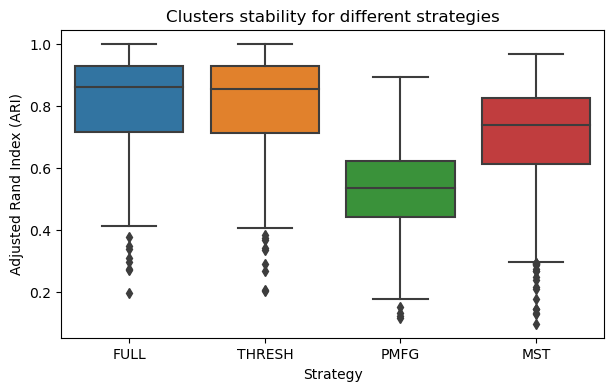

In [5]:
fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for s in clustering_stability[c]],
                   'Value': [s for c in clustering_list for s in clustering_stability[c]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Clusters stability for different strategies')

# Show the plot
plt.show()

In [6]:
def compute_nb_clusters(clusters):
    """
    Compute the number of clusters for each cluster assignment in a dictionary.

    Parameters:
    - clusters (dict): A dictionary where keys are cluster names and values are cluster assignments.

    Returns:
    - list_nb_clusters (list): A list containing the number of clusters for each cluster assignment.
    """
    nb_clusters = len(clusters.keys())
    list_nb_clusters = []

    # Iterate through clusters and calculate the number of clusters
    for i in range(nb_clusters):
        # Retrieve cluster assignments and calculate the number of clusters
        # The values go from 0 to nb, that's why max() - 1 is used
        cluster_assignments = clusters[list(clusters.keys())[i]].values()
        nb = max(cluster_assignments) - 1
        list_nb_clusters.append(nb)

    return list_nb_clusters

In [7]:
clustering_sizes = {}
for i in range(len(clustering_list)):
    # Calculate and store the number of clusters for each clustering method
    clustering_sizes[clustering_list[i]] = compute_nb_clusters(all_clustering[clustering_list[i]])

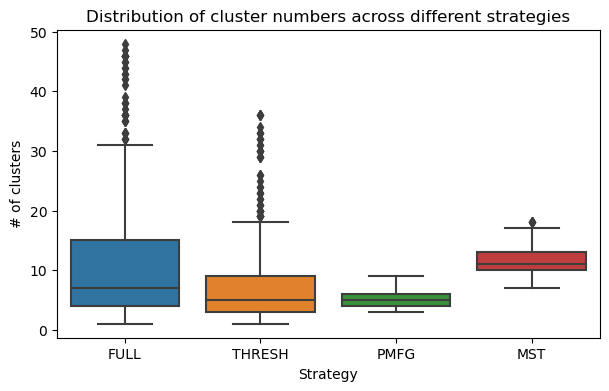

In [8]:
fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for size in clustering_sizes[c]],
                   'Value': [size for c in clustering_list for size in clustering_sizes[c]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel('# of clusters')
plt.title('Distribution of cluster numbers across different strategies')

# Show the plot
plt.show()

## Anaylsis of the out-sample-risk of optimal portfolios based on the clusters 

In [9]:
def find_representatives(clusters, df):
    """
    Identify representative elements for each community within a clustering result.

    Parameters:
    - clusters (dict): A dictionary where keys are cluster names and values are cluster assignments.
    - df (pd.DataFrame): The DataFrame containing the normalized log returns.

    Returns:
    - representatives (list): A list of lists, where each sublist contains representative elements for each community.
    """
    nb_clustering = len(clusters.keys())
    representatives = []

    # Iterate through clusters
    for i in range(nb_clustering):
        current_representatives = []
        current_cluster = clusters[list(clusters.keys())[i]]

        # Loop through each community
        for group in range(1, max(current_cluster.values()) + 1):  # Adjusted the range to start from 1
            subset = [cluster[0] for cluster in current_cluster.items() if cluster[1] == group]
            
            # Subset the data for the current group
            subset_data = df[subset]

            # Apply PCA
            pca = PCA()
            principal_components = pca.fit_transform(subset_data)

            # Identify the leading coin (biggest contributor in the first principal component)
            leading_coin_index = np.argmax(np.abs(pca.components_[0]))
            leading_coin = subset_data.columns[leading_coin_index]
            current_representatives.append(leading_coin)
            
        representatives.append(current_representatives)
    
    return representatives

In [13]:
def out_sample_risks(clusters, representatives, df):
    """
    Calculate out-of-sample risks for each clustering result based on provided representatives.

    Parameters:
    - clusters (dict): A dictionary where keys are cluster names and values are cluster assignments.
    - representatives (list): A list of lists containing representative elements for each community.
    - df (pd.DataFrame): The DataFrame containing the normalized log returns.

    Returns:
    - out_vol (list): A list of out-of-sample volatilities for each clustering result.
    - vol_abs (list): A list of absolute relative differences between realized and out-of-sample volatilities.
    """
    nb_clustering = len(clusters.keys())
    out_vol = []
    vol_abs = []

    # Iterate through clusters
    for i in range(nb_clustering):
        # Calculate the length of the window for the current cluster
        length_window = list(clusters.keys())[i][1] - list(clusters.keys())[i][0]

        # Extract in-sample and out-of-sample correlation matrices based on representatives
        corr_mat_insample = df.loc[list(clusters.keys())[i][0]:list(clusters.keys())[i][1], representatives[i]].corr()
        corr_mat_outsample = df.loc[list(clusters.keys())[i][1]:list(clusters.keys())[i][1] + length_window, representatives[i]].corr()

        # Calculate inverse of in-sample correlation matrix
        inv_corr_insample = LA.inv(corr_mat_insample.to_numpy())

        # Calculate optimal weights using the inverse correlation matrix
        w_opt = inv_corr_insample @ np.ones(len(inv_corr_insample)) / (np.ones(len(inv_corr_insample)) @ inv_corr_insample @ np.ones(len(inv_corr_insample)))

        # Calculate realized and out-of-sample volatilities
        realized_vol = np.sqrt(w_opt @ corr_mat_insample @ w_opt.T)
        out_sample_vol = np.sqrt(w_opt @ corr_mat_outsample @ w_opt.T)

        # Append results to lists
        out_vol.append(out_sample_vol)
        vol_abs.append(abs(realized_vol - out_sample_vol) / realized_vol)

    return out_vol, vol_abs

In [14]:
df = pd.read_csv("../data/processed/normalized_log_ret.csv")

clustering_out_vol = {}

# Iterate through clustering methods in the clustering_list
for method in clustering_list:
    # Find representatives for the current clustering method
    representatives = find_representatives(all_clustering[method], df)

    # Calculate out-of-sample risks and store the results in clustering_out_vol dictionary
    clustering_out_vol[method] = out_sample_risks(all_clustering[method], representatives, df)

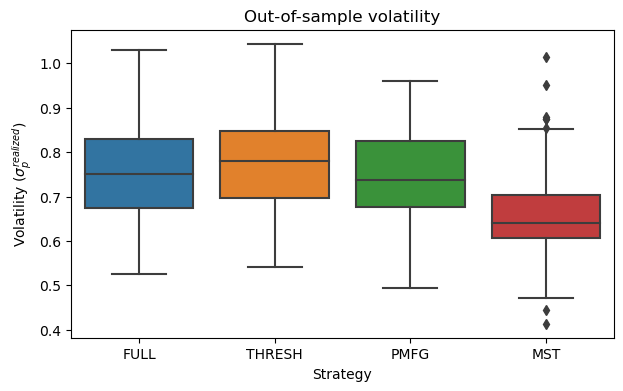

In [15]:
# Plot for the out-of-sample volatility

fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for risk in clustering_out_vol[c][0]],
                   'Value': [s for c in clustering_list for s in clustering_out_vol[c][0]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel(r'Volatility ($\sigma_p^{realized}$)')
plt.title('Out-of-sample volatility')

# Show the plot
plt.show()

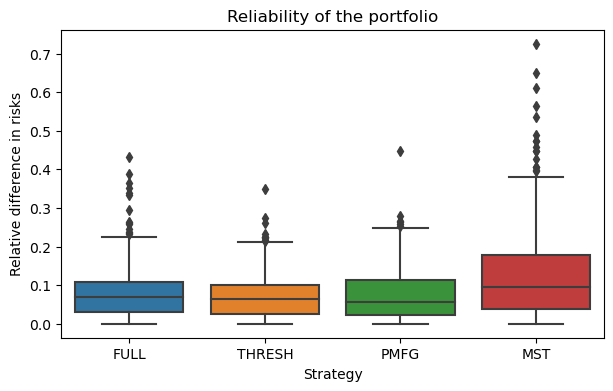

In [16]:
# Reliability of the portfolio (relative differences of volatility)

fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for risk in clustering_out_vol[c][1]],
                   'Value': [s for c in clustering_list for s in clustering_out_vol[c][1]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel(r'Relative difference in risks')
plt.title('Reliability of the portfolio')

# Show the plot
plt.show()